<a href="https://colab.research.google.com/github/trashchenkov/gigachat_tutorials/blob/main/ReAct_with_Middleware.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LangChain 1.0
В этом туториале мы постараемся разобраться как работает выпущенный в октябре 2025 года обновленный фреймворк LangChain.

Если вы ранее не взаимодействовали с LLM по API и не создавали агентов самостоятельно, то советую сперва ознакомиться с моим мастер-классом на AI Journey "Создай своего первого ИИ-агента":
- [Youtube](https://youtu.be/DOSt8X1Ee4c)
- [Rutube](https://rutube.ru/video/8915b46d7fb2bd30819e047875f356a2/)
- [VK](https://vk.com/video-22522055_456246105)

Там показаны процессы получения ключей доступа к GigaChat API, создания отдельных вызовов к LLM, а также построения простых ИИ-агентов. Ознакомившись с мастер-классом, вам проще будет ориентироваться в этом туториале.  



## ReAct-агент

Основой обновленной версии LangChain 1.0 является абстракция `create_agent()`. Это функция, которая создает ReAct-паттерн в виде графа на LangGraph. Это готовая конфигурация, чтобы использовать в качестве агента.

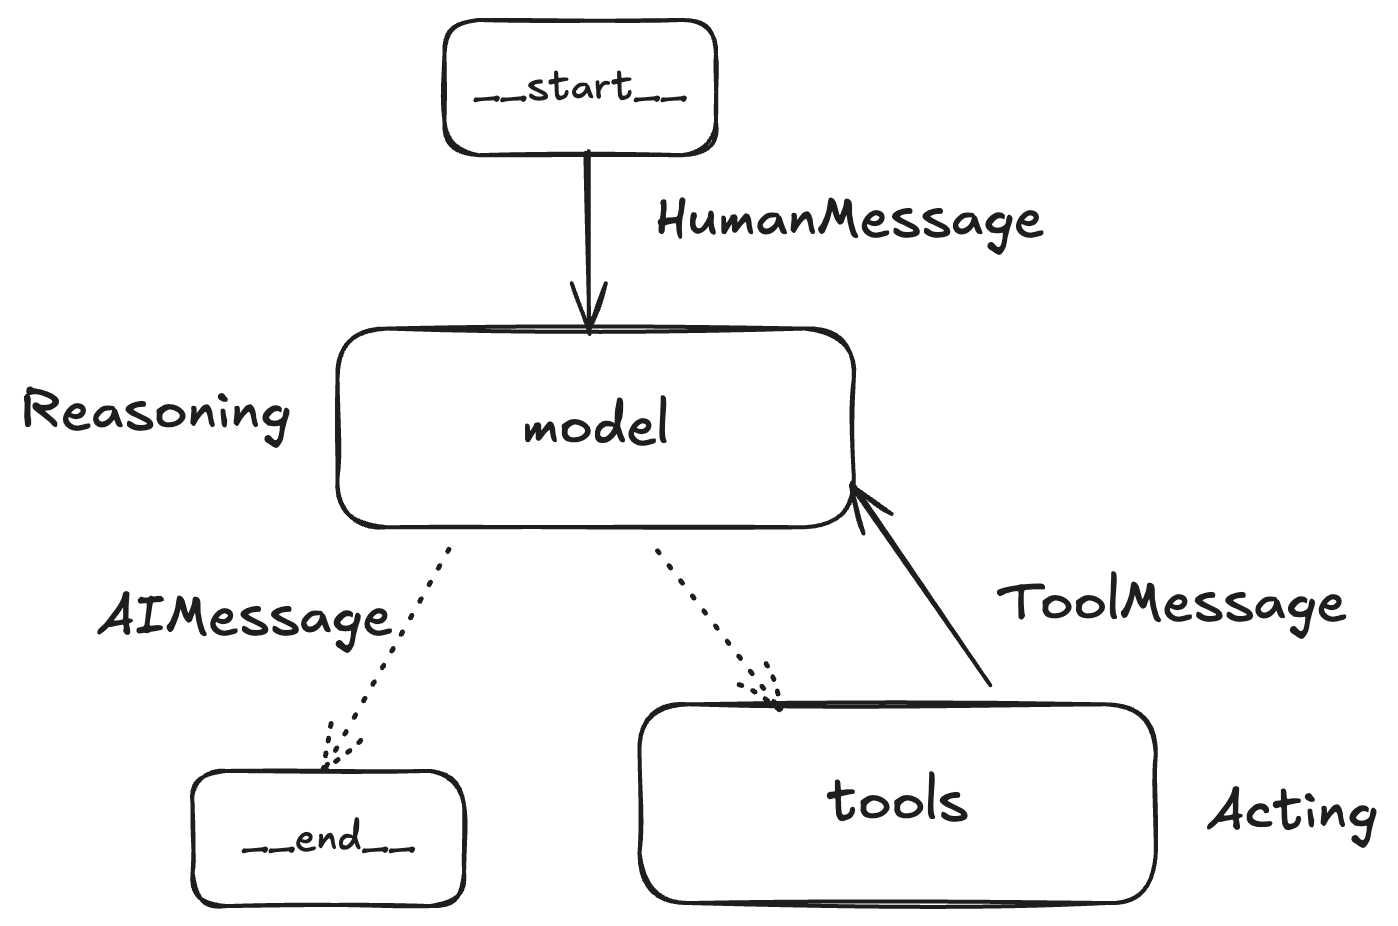

В рамках туториала мы рассмотрим пример агента, работающего с SQLite БД. Он будет обладать несколькими инструментами:

- создавать задачу
- показать список задач
- изменить статус по задаче
- удалить задачу

Для простоты мы будем работать всего с одной таблицей, описывающей задачи, у которой будут следующие поля:
- id - идентификатор
- title - текстовое описание задачи
- status - статус по задаче
- priority - приоритетность задачи, по умолчанию 1, чем выше, тем приоритетнее задача
- due_date - дедлайн по задаче, поле может быть пустым



### Установка библиотек

In [1]:
!pip install -U -q langchain langchain-gigachat==0.3.13a2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.9/69.9 kB 2.2 MB/s eta 0:00:00


### Создание БД

In [14]:
import sqlite3
from pathlib import Path

DB_PATH = Path("tasks.db")


def get_conn() -> sqlite3.Connection:
    """Открываем подключение к SQLite (по одному коннекту на вызов тула)."""
    conn = sqlite3.connect(DB_PATH)
    conn.row_factory = sqlite3.Row
    return conn


def init_db() -> None:
    """Создаём таблицу tasks, если её ещё нет."""
    conn = get_conn()
    with conn:
        conn.execute(
            """
            CREATE TABLE IF NOT EXISTS tasks (
                id       INTEGER PRIMARY KEY AUTOINCREMENT,
                title    TEXT NOT NULL,
                status   TEXT NOT NULL DEFAULT 'todo',
                priority INTEGER NOT NULL DEFAULT 1,
                due_date TEXT
            )
            """
        )
    conn.close()


# один раз инициализируем схему
init_db()


### Создание инструментов и самого агента

In [3]:
from langchain.tools import tool

@tool(parse_docstring=True)
def add_task(
    title: str,
    status: str = "todo",
    priority: int = 1,
    due_date: str | None = None,
) -> str:
    """Добавить новую задачу в базу данных.

    Args:
        title: Краткое текстовое описание задачи.
        status: Статус задачи. Ожидаются значения "todo", "in_progress" или "done".
        priority: Приоритет задачи как целое число. Чем больше число, тем выше приоритет.
        due_date: Необязательная дата дедлайна в формате YYYY-MM-DD. Используйте
            None или пустую строку, если дедлайн не указан.

    Returns:
        Строка с информацией о созданной задаче, включая её идентификатор.
    """
    conn = get_conn()
    with conn:
        conn.execute(
            """
            INSERT INTO tasks (title, status, priority, due_date)
            VALUES (?, ?, ?, ?)
            """,
            (title, status, priority, due_date),
        )
        row = conn.execute(
            "SELECT last_insert_rowid() AS id"
        ).fetchone()
        task_id = row["id"]
    conn.close()
    return (
        f"Задача #{task_id} создана: {title!r} "
        f"(status={status}, priority={priority}, due_date={due_date})"
    )


@tool(parse_docstring=True)
def list_tasks(status: str | None = None) -> str:
    """Показать список задач из базы данных.

    Args:
        status: Необязательный статус для фильтрации. Если указан, должен быть
            одним из "todo", "in_progress" или "done". Если параметр не задан
            или пустой, выводятся все задачи.

    Returns:
        Человекочитаемый список задач с их идентификаторами, статусами,
        приоритетами и дедлайнами.
    """
    conn = get_conn()
    if status:
        rows = conn.execute(
            """
            SELECT id, title, status, priority, COALESCE(due_date, '') AS due_date
            FROM tasks
            WHERE status = ?
            ORDER BY priority DESC, id ASC
            """,
            (status,),
        ).fetchall()
    else:
        rows = conn.execute(
            """
            SELECT id, title, status, priority, COALESCE(due_date, '') AS due_date
            FROM tasks
            ORDER BY priority DESC, id ASC
            """
        ).fetchall()
    conn.close()

    if not rows:
        if status:
            return f"Задач со статусом {status!r} не найдено."
        return "В базе пока нет задач."

    lines: list[str] = ["Текущие задачи:"]
    for r in rows:
        line = f"#{r['id']}: [{r['status']}] (p={r['priority']}) {r['title']}"
        if r["due_date"]:
            line += f" (due={r['due_date']})"
        lines.append(line)
    return "\n".join(lines)


@tool(parse_docstring=True)
def update_task_status(task_id: int, new_status: str) -> str:
    """Изменить статус существующей задачи.

    Args:
        task_id: Идентификатор задачи, статус которой нужно изменить.
        new_status: Новый статус задачи. Должен быть одним из:
            "todo", "in_progress" или "done".

    Returns:
        Краткое текстовое сообщение с результатом изменения.
    """
    conn = get_conn()
    with conn:
        cur = conn.execute(
            "UPDATE tasks SET status = ? WHERE id = ?",
            (new_status, task_id),
        )
        updated = cur.rowcount
    conn.close()

    if updated == 0:
        return f"Задача с id={task_id} не найдена."
    return f"Статус задачи #{task_id} изменён на {new_status!r}."


@tool(parse_docstring=True)
def delete_task(task_id: int) -> str:
    """Удалить задачу из базы данных.

    Args:
        task_id: Идентификатор задачи, которую нужно удалить.

    Returns:
        Краткое текстовое сообщение с информацией о том,
        была ли задача удалена.
    """
    conn = get_conn()
    with conn:
        cur = conn.execute(
            "DELETE FROM tasks WHERE id = ?",
            (task_id,),
        )
        deleted = cur.rowcount
    conn.close()

    if deleted == 0:
        return f"Задача с id={task_id} не найдена."
    return f"Задача #{task_id} удалена."


In [13]:
from langchain_gigachat import GigaChat
from langchain.agents import create_agent
from google.colab import userdata
from langgraph.checkpoint.memory import InMemorySaver

# базовая модель без всякого middleware
llm = GigaChat(
    credentials=userdata.get('SBER_CORP'),
    scope="GIGACHAT_API_CORP",
    verify_ssl_certs=False,
    temperature=0.1,
    model='GigaChat-2-Max'
)

checkpointer = InMemorySaver()

agent = create_agent(
    model=llm,
    tools=[add_task, list_tasks, update_task_status, delete_task],
    checkpointer=checkpointer,
)

config_tasks = {"configurable": {"thread_id": "tasks-demo"}}

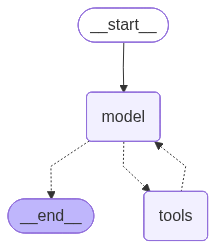

In [5]:
agent

In [15]:
res = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": (
                    "У тебя есть инструменты для работы с базой задач. "
                    "Сделай следующее:\n"
                    "1) Добавь три задачи:\n"
                    "   - 'Подготовить отчёт по продажам за квартал' со статусом in_progress, приоритет 5, дедлайн 2025-12-01.\n"
                    "   - 'Позвонить клиенту по продлению контракта' со статусом todo, приоритет 4, без дедлайна.\n"
                    "   - 'Разобрать почту' со статусом todo, приоритет 1, без дедлайна.\n"
                    "2) После этого выведи список всех задач из базы.\n"
                    "Пожалуйста, сначала вызови нужные инструменты, а в финальном ответе "
                    "дай понятное резюме того, что ты сделал, и список задач."
                ),
            }
        ]
    },
    config_tasks,
)




In [16]:
for msg in res["messages"]:
        msg.pretty_print()


================================ Human Message =================================

У тебя есть инструменты для работы с базой задач. Сделай следующее:
1) Добавь три задачи:
   - 'Подготовить отчёт по продажам за квартал' со статусом in_progress, приоритет 5, дедлайн 2025-12-01.
   - 'Позвонить клиенту по продлению контракта' со статусом todo, приоритет 4, без дедлайна.
   - 'Разобрать почту' со статусом todo, приоритет 1, без дедлайна.
2) После этого выведи список всех задач из базы.
Пожалуйста, сначала вызови нужные инструменты, а в финальном ответе дай понятное резюме того, что ты сделал, и список задач.
================================== Ai Message ==================================
Tool Calls:
  add_task (9da155db-8dc2-4c2e-8a4c-878a829bb7c0)
 Call ID: 9da155db-8dc2-4c2e-8a4c-878a829bb7c0
  Args:
    due_date: 2025-12-01
    priority: 5
    status: in_progress
    title: Подготовить отчёт по продажам за квартал
================================= Tool Message =========================

Чтобы убедиться, что агент отработал верно, используем вспомогательную функцию, показывающую содержимое БД.

In [8]:
def debug_print_all_tasks() -> None:
    """Отладочный вывод всех задач из таблицы tasks."""
    conn = get_conn()
    rows = conn.execute(
        """
        SELECT id, title, status, priority, COALESCE(due_date, '') AS due_date
        FROM tasks
        ORDER BY id ASC
        """
    ).fetchall()
    conn.close()

    if not rows:
        print("В базе нет задач.")
        return

    print("=== Все задачи в БД ===")
    for r in rows:
        line = f"#{r['id']}: [{r['status']}] (p={r['priority']}) {r['title']}"
        if r["due_date"]:
            line += f" (due={r['due_date']})"
        print(line)


In [9]:
debug_print_all_tasks()

=== Все задачи в БД ===
#1: [in_progress] (p=5) Подготовить отчёт по продажам за квартал (due=2025-12-01)
#2: [todo] (p=4) Позвонить клиенту по продлению контракта
#3: [todo] (p=1) Разобрать почту


## Context Engineering в LangChain 1.0

Однако, LangChain 1.0 создавался в рамках парадигмы **контекст инжиниринга**. Суть контекст инжиниринга в том, что агенты могут решать поставленную задачу достаточно долго, на протяжении десятков шагов (под шагом мы понимаем  вызов LLM). И на каждом шаге агент должен получать контекст, нужный именно для этого шага. Под контекстом здесь мы понимаем информацию, подаваемую на вход LLM. Задача разработчика агента - написать такой код, который будет правильно управлять этим контекстом.

В [разделе документации LangChain 1.0, посвещенном контекст инжинирингу](https://docs.langchain.com/oss/python/langchain/context-engineering), предлагается управлять контекстом на трех уровнях:

- Контекст модели (Model Context)
- Контекст инструментов (Tool Context)
- Контекст жизненного цикла (Life-cycle Context)


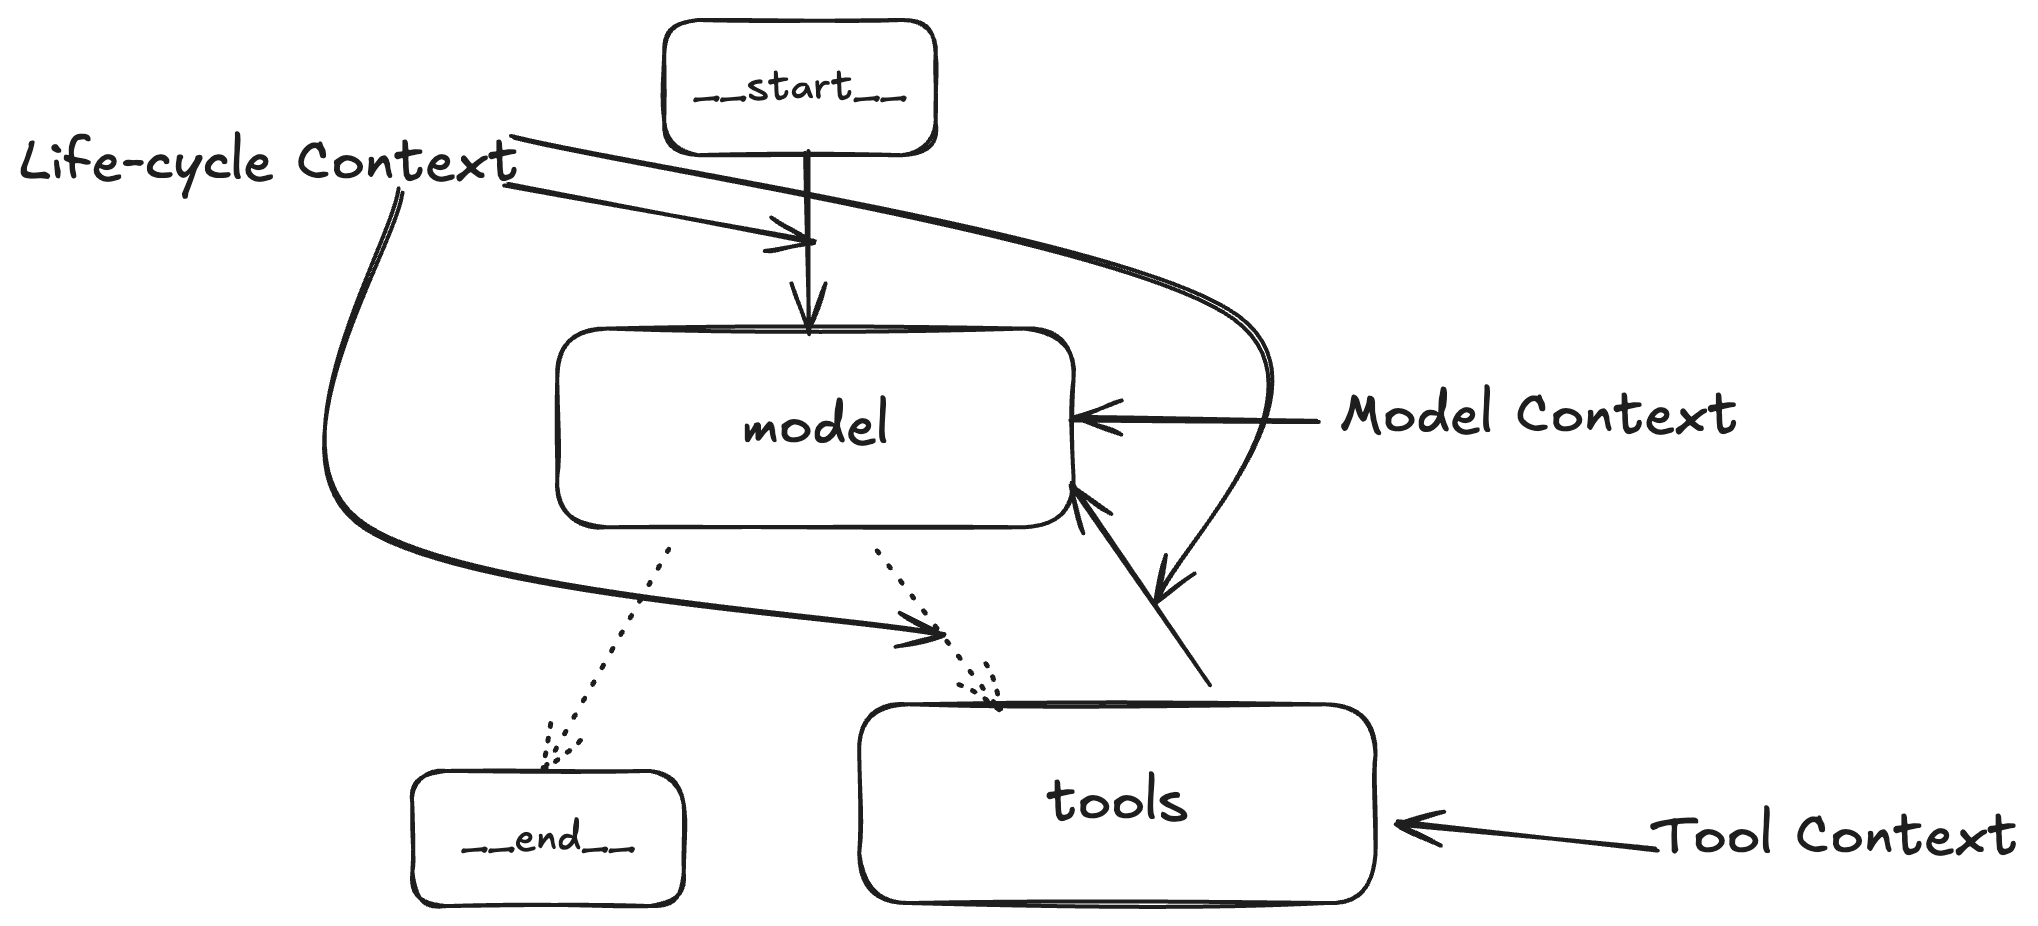

Кратко охарактеризуем каждый уровень. **Model Context** охватывает все, что непосредственно передается в модель при вызове: системный промпт, история сообщений, описание инструментов и формат вывода итогового ответа. Это “временный” контекст: мы можем на каждом шаге перед отправкой запроса в LLM дописывать или изменять промпт (добавлять служебные инструкции, подсказки, куски текста, подключать или отключать инструменты), чтобы получить нужное поведение модели, но при этом эти изменения не обязаны попадать в сохранённую историю диалога. В state остаются только те сообщения, которые мы явно туда кладём, а все промежуточные “надстройки” живут только в рамках конкретного вызова модели.

**Tool Context** относится ко всем операциям, которые выполняются внутри инструментов. Инструменты могут не только получать аргументы от LLM, но и дополнительную информацию, которая не видна модели, но может определять возможности и логику работы инструмента.

ReAct-агент работает в цикле из двух действий: вызова LLM и выполнения инструментов. **Life-cycle Context** представляет собой всю логику, которая выполняется между вызовами модели и инструментов. Сюда относятся, например, логирование, применение ограничений (guardrails), суммаризация диалога или human-in-the-loop.


Таким образом, хотя базово мы имеем дело с одним лишь ReAct-паттерном, нам доступно множество "степеней свободы" для тонкой настройки агента.


Чтобы осуществлять такую настройку, в LangChain 1.0 используются два ключевых механизма:

- Middleware — прослойки-перехватчики вокруг шагов агента. С их помощью мы можем динамически менять запросы к модели, обновлять состояние и долгосрочную память и при необходимости даже менять маршрут исполнения между нодами графа (например, сразу завершить агент, не доходя до инструментов).

- Tool runtime (ToolRuntime) — специальный параметр, который можно принять в инструменте. Он не виден модели и заполняется рантаймом: через него инструмент получает доступ к state, store и runtime-контексту и может на этой основе менять свою логику и записывать новые данные.

### Model Context
#### Модификация сообщений
Middleware в графе агента могут представлять собой одну из двух сущностей:
- обертку над обращением к модели или инструменту, которая перехватывает обработку и модифицирует что-нибудь (сообщения, список инструментов и т.д.)
- отдельную ноду графа, которая создает дополнительный этап обработки (а если появляются новые ноды, то с ними появляются и новые ребра)

В рамках Model Context у нас будут преимущественно обертки.

Сперва посмотрим, как можно добавить системное сообщение на этапе обращения к модели, которого не будет в истории сообщений. Для этого используем декоратор `@wrap_model_call`, а в функцию под декоратором передадим объект ModelRequest, содержащий всю информацию по текущему запросу, и обработчик Callable[ModelRequest], ModelResponse], который принимает запрос к модели и возвращает ответ.

Эти декораторы мы будем использовать во всех middleware-обертках.

In [17]:
from langchain.agents.middleware import (
    wrap_model_call,
    ModelRequest,
    ModelResponse,
)
from typing import Callable
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage


DB_SCHEMA_TEXT = """
Ты работаешь с базой данных SQLite с одной таблицей tasks.

Структура таблицы tasks:
- id: INTEGER PRIMARY KEY AUTOINCREMENT — уникальный идентификатор задачи.
- title: TEXT — краткое название задачи.
- status: TEXT — строка со статусом, одно из значений: "todo", "in_progress", "done".
- priority: INTEGER — приоритет задачи, целое число (чем больше, тем важнее).
- due_date: TEXT или NULL — дата дедлайна в формате YYYY-MM-DD, либо отсутствие дедлайна.

Всегда считай, что реальные данные задач находятся в этой таблице, и любые операции
с задачами нужно выполнять через инструменты (add_task, list_tasks, update_task_status, delete_task).
Не выдумывай задачи, которых нет в базе.
""".strip()


@wrap_model_call
def inject_db_schema(
    request: ModelRequest,
    handler: Callable[[ModelRequest], ModelResponse],
) -> ModelResponse:
    """На каждый вызов модели подмешивает описание схемы БД как системное сообщение.

    Это изменение только для текущего вызова LLM и не попадает в сохранённую историю.
    """
    schema_message = SystemMessage(DB_SCHEMA_TEXT)
    new_messages = [schema_message, *request.messages]
    print("\n=== MESSAGES, которые пойдут в LLM (с схемой БД) ===")
    for i, m in enumerate(new_messages):
        print(f"{i}. {type(m)}: {str(m.content)[:80]!r}")



    new_request = request.override(messages=new_messages)
    return handler(new_request)


# агент для демо messages-injection
checkpointer_schema = MemorySaver()

agent_schema_injection = create_agent(
    model=llm,
    tools=[add_task, list_tasks, update_task_status, delete_task],
    middleware=[inject_db_schema],
    checkpointer=checkpointer_schema,
)

# пример вызова
config_schema = {"configurable": {"thread_id": "tasks-schema-demo"}}

res = agent_schema_injection.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": (
                    "Добавь задачу 'Проверить структуру БД' со статусом todo "
                    "и приоритетом 3, а потом покажи список всех задач."
                ),
            }
        ]
    },
    config_schema,
)





=== MESSAGES, которые пойдут в LLM (с схемой БД) ===
0. <class 'langchain_core.messages.system.SystemMessage'>: 'Ты работаешь с базой данных SQLite с одной таблицей tasks.\n\nСтруктура таблицы ta'
1. <class 'langchain_core.messages.human.HumanMessage'>: "Добавь задачу 'Проверить структуру БД' со статусом todo и приоритетом 3, а потом"

=== MESSAGES, которые пойдут в LLM (с схемой БД) ===
0. <class 'langchain_core.messages.system.SystemMessage'>: 'Ты работаешь с базой данных SQLite с одной таблицей tasks.\n\nСтруктура таблицы ta'
1. <class 'langchain_core.messages.human.HumanMessage'>: "Добавь задачу 'Проверить структуру БД' со статусом todo и приоритетом 3, а потом"
2. <class 'langchain_core.messages.ai.AIMessage'>: ''
3. <class 'langchain_core.messages.tool.ToolMessage'>: "Задача #4 создана: 'Проверить структуру БД' (status=todo, priority=1, due_date=N"

=== MESSAGES, которые пойдут в LLM (с схемой БД) ===
0. <class 'langchain_core.messages.system.SystemMessage'>: 'Ты работаешь с баз

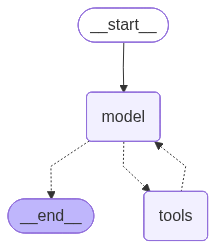

In [11]:
agent_schema_injection

In [18]:
for msg in res["messages"]:
        msg.pretty_print()

================================ Human Message =================================

Добавь задачу 'Проверить структуру БД' со статусом todo и приоритетом 3, а потом покажи список всех задач.
================================== Ai Message ==================================
Tool Calls:
  add_task (83b8e8c0-9135-42f1-b353-c3804ea482bd)
 Call ID: 83b8e8c0-9135-42f1-b353-c3804ea482bd
  Args:
    title: Проверить структуру БД
================================= Tool Message =================================
Name: add_task

Задача #4 создана: 'Проверить структуру БД' (status=todo, priority=1, due_date=None)
================================== Ai Message ==================================
Tool Calls:
  list_tasks (01e12b00-08f2-465c-b168-726aca3e9310)
 Call ID: 01e12b00-08f2-465c-b168-726aca3e9310
  Args:
================================= Tool Message =================================
Name: list_tasks

Текущие задачи:
#1: [in_progress] (p=5) Подготовить отчёт по продажам за квартал (due=2025-12-01)


#### Модификация списка инструментов
Используем Middleware для передачи в модель урезанного списка инструментов. Убедимся, что это влияет на возможности агента. Например,представим, что у агента теперь есть два режима работы: plan и apply. В первом будет доступен только один инструмент для чтения списка задач. Во втором - все инструменты без ограничений.

Дадим задачу на удаление записи из таблицы в обоих режимах.

In [19]:
from dataclasses import dataclass
from typing import Callable

from langchain.agents.middleware import (
    wrap_model_call,
    ModelRequest,
    ModelResponse,
)
from langgraph.checkpoint.memory import MemorySaver

# тут считаем, что у тебя уже есть:
# llm, add_task, list_tasks, update_task_status, delete_task


@dataclass
class AgentContext:
    """Контекст агента.

    mode:
        "plan"  — режим планирования (не менять БД).
        "apply" — режим применения (можно менять БД).
    """
    mode: str = "apply"


@wrap_model_call
def plan_apply_tools(
    request: ModelRequest,
    handler: Callable[[ModelRequest], ModelResponse],
) -> ModelResponse:
    """Динамически меняет список доступных тулов в зависимости от режима.

    - В режиме 'plan' оставляем только list_tasks.
    - В режиме 'apply' оставляем все тулы.

    Плюс подмешиваем короткое системное сообщение с пояснением режима.
    """
    ctx = getattr(request.runtime, "context", None)
    mode = getattr(ctx, "mode", "apply") if ctx is not None else "apply"

    tools = request.tools
    messages = list(request.messages)

    if mode == "plan":
        # только чтение — оставляем один тул list_tasks
        allowed_names = {"list_tasks"}
        tools = [t for t in tools if t.name in allowed_names]

        messages.insert(
            0,
            {
                "role": "system",
                "content": (
                    "Сейчас ты работаешь в режиме ПЛАНИРОВАНИЯ (plan).\n"
                    "Ты НЕ должен изменять данные в БД. Не вызывай инструменты "
                    "для добавления, обновления или удаления задач.\n"
                    "Используй list_tasks, чтобы посмотреть текущие задачи, "
                    "и давай рекомендации в текстовом виде."
                ),
            },
        )
    else:
        messages.insert(
            0,
            {
                "role": "system",
                "content": (
                    "Сейчас ты работаешь в режиме ПРИМЕНЕНИЯ (apply).\n"
                    "Ты МОЖЕШЬ вызывать инструменты add_task, update_task_status "
                    "и delete_task, если это логично по запросу пользователя.\n"
                    "Если ранее был согласован план, следуй ему."
                ),
            },
        )

    new_request = request.override(messages=messages, tools=tools)
    return handler(new_request)


checkpointer_mode = MemorySaver()

agent_plan_apply = create_agent(
    model=llm,
    tools=[add_task, list_tasks, update_task_status, delete_task],
    middleware=[plan_apply_tools],
    checkpointer=checkpointer_mode,
    context_schema=AgentContext,
)


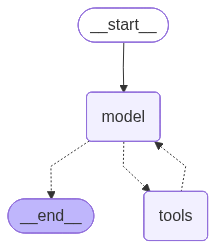

In [20]:
agent_plan_apply

In [21]:
# 1) Режим PLAN — только анализ, без изменений в БД
ctx_plan = AgentContext(mode="plan")
config_mode = {"configurable": {"thread_id": "tasks-plan-apply-demo"}}

res_plan = agent_plan_apply.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": (
                    "Удали последнюю задачу из списка задач"
                ),
            }
        ]
    },
    config_mode,
    context=ctx_plan,
)

print("=== PLAN MODE ===")


for msg in res_plan["messages"]:
        msg.pretty_print()

=== PLAN MODE ===
================================ Human Message =================================

Удали последнюю задачу из списка задач
================================== Ai Message ==================================

Давай сначала посмотрим на текущий список задач, прежде чем что-либо удалять. Использую инструмент `list_tasks`, чтобы получить актуальный список:
Tool Calls:
  list_tasks (36b4a5f3-7b93-477f-affb-505e08d475a4)
 Call ID: 36b4a5f3-7b93-477f-affb-505e08d475a4
  Args:
================================= Tool Message =================================
Name: list_tasks

Текущие задачи:
#1: [in_progress] (p=5) Подготовить отчёт по продажам за квартал (due=2025-12-01)
#2: [todo] (p=4) Позвонить клиенту по продлению контракта
#3: [todo] (p=1) Разобрать почту
#4: [todo] (p=1) Проверить структуру БД
================================== Ai Message ==================================

Последняя задача в списке — это «Проверить структуру БД». 

Однако я не могу удалить её прямо сейчас, т

In [22]:
# 2) Режим APPLY — можно реально менять БД
ctx_apply = AgentContext(mode="apply")

res_apply = agent_plan_apply.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "Удали последнюю задачу из списка задач",
            }
        ]
    },
    config_mode,
    context=ctx_apply,
)

for msg in res_apply["messages"]:
    msg.pretty_print()


================================ Human Message =================================

Удали последнюю задачу из списка задач
================================== Ai Message ==================================

Давай сначала посмотрим на текущий список задач, прежде чем что-либо удалять. Использую инструмент `list_tasks`, чтобы получить актуальный список:
Tool Calls:
  list_tasks (36b4a5f3-7b93-477f-affb-505e08d475a4)
 Call ID: 36b4a5f3-7b93-477f-affb-505e08d475a4
  Args:
================================= Tool Message =================================
Name: list_tasks

Текущие задачи:
#1: [in_progress] (p=5) Подготовить отчёт по продажам за квартал (due=2025-12-01)
#2: [todo] (p=4) Позвонить клиенту по продлению контракта
#3: [todo] (p=1) Разобрать почту
#4: [todo] (p=1) Проверить структуру БД
================================== Ai Message ==================================

Последняя задача в списке — это «Проверить структуру БД». 

Однако я не могу удалить её прямо сейчас, так как у меня нет 

#### Получение структурированного ответа

Для получения структурированного ответа, нужно заставить модель сгенерировать последнее сообщение особым образом. Для реализации этого в LangChain 1.0 существенно модифицируется граф ReAct-агента. Подробнее об этом читайте в [документации](https://docs.langchain.com/oss/python/langchain/structured-output).

Для структурированного ответа нужно создать описание структуры в виде Pydantic-модели. Опишем желаемый формат ответа в виде списка задач, где каждая задача состоит из определенного набора полей.

In [23]:
from pydantic import BaseModel, Field
from typing import List, Literal


class TaskInfo(BaseModel):
    """Сведение по одной задаче из БД после шага агента."""
    id: int = Field(description="ID задачи из таблицы tasks")
    title: str = Field(description="Название задачи")
    status: Literal["todo", "in_progress", "done"] = Field(

        description="Текущий статус задачи"
    )
    priority: int = Field(description="Приоритет задачи (чем больше, тем важнее)")
    due_date: str = Field(
        description="Дедлайн в формате YYYY-MM-DD или пустая строка, если дедлайн не задан"
    )


class TaskAgentResponse(BaseModel):
    """Структурированный ответ агента по задачам."""
    explanation: str = Field(
        description="Краткое человеческое объяснение того, что сделал агент"
    )
    tasks: List[TaskInfo] = Field(
        description="Список задач после выполнения запроса пользователя"
    )


Теперь передадим формат ответа в создаваемого агента.

In [24]:
from langchain.agents import create_agent
from langgraph.checkpoint.memory import MemorySaver

checkpointer_structured = MemorySaver()

agent_structured = create_agent(
    model=llm,
    tools=[add_task, list_tasks, update_task_status, delete_task],
    response_format=TaskAgentResponse,   # <-- ключевое отличие
    checkpointer=checkpointer_structured,
)


Получили агента, который имеет ряд отличий от обычного ReAct-паттерна. Дело в том, что структурированный ответ в зависимости от модели, получают двумя возможными способами. Большинство моделей создают структурированный ответ с помощью дополнительного инструмента, который возникает на основе описанной Pydantic-модели. Поэтому агент, после того как вызвал все необходимые инструменты, вызывает этот дополнительный инструмент

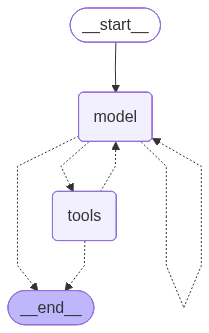

In [25]:
agent_structured

In [26]:
config_structured = {"configurable": {"thread_id": "tasks-structured-demo"}}

res = agent_structured.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": (
                    "Добавь задачу 'Сделать бэкап БД' со статусом todo и приоритетом 4, "
                    "а затем выведи список задач."
                ),
            }
        ]
    },
    config_structured,
)

print("=== Сообщения (как обычно) ===")
for m in res["messages"]:
    m.pretty_print()



=== Сообщения (как обычно) ===
================================ Human Message =================================

Добавь задачу 'Сделать бэкап БД' со статусом todo и приоритетом 4, а затем выведи список задач.
================================== Ai Message ==================================
Tool Calls:
  add_task (c353c183-311d-45de-afdd-668f74c73e5e)
 Call ID: c353c183-311d-45de-afdd-668f74c73e5e
  Args:
    priority: 4
    status: todo
    title: Сделать бэкап БД
================================= Tool Message =================================
Name: add_task

Задача #5 создана: 'Сделать бэкап БД' (status=todo, priority=4, due_date=None)
================================== Ai Message ==================================
Tool Calls:
  list_tasks (5da33cb1-7550-42cc-902d-f21049705f1d)
 Call ID: 5da33cb1-7550-42cc-902d-f21049705f1d
  Args:
================================= Tool Message =================================
Name: list_tasks

Текущие задачи:
#1: [in_progress] (p=5) Подготовить отчёт

### Tool Context
#### Чтение и запись

В рамках демонстрации Tool Context используем долгосрочную память, в которой будем хранить сведения о пользователе. В нашем случае это будут id пользователя, его роль (администратор или просто пользователь) и режим работы агента (plan или apply).

Информация из долгосрочной памяти будет попадать в инструмент удаления задачи через `ToolRuntime` (агент не будет видеть или заполнять эти поля).

Внутри инструмента `delete_task()` пусть будет прописана следующая логика:
- если у агента роль простого пользователя, то он не сможет выполнить операцию удаления записи
- если же агент в роли администратора и в режиме plan, то при первом обращении к `delete_task()` у него меняется режим на apply и возвращается сообщение, что для подтверждения удаления, нужно вызвать инструмент еще раз

Пусть внешний контекст описывается передаваемым user_id

In [27]:
@dataclass
class Context:
    user_id: str


Создадим двух пользователей в режиме plan, один из которых администратор, а второй - просто пользователь.

In [33]:
from langgraph.store.memory import InMemoryStore

store = InMemoryStore()

# пусть user_123 — наш первый тестовый пользователь
store.put(
    ("agent_settings",),  # namespace
    "user_123",           # key
    {"role": "admin", "mode": "plan"},
)

# а user_456 — наш второй тестовый пользователь
store.put(
    ("agent_settings",),  # namespace
    "user_456",           # key
    {"role": "user", "mode": "plan"},
)


Опишем обновленный код инструмента `delete_task()`.

In [34]:
from langchain.tools import tool, ToolRuntime

@tool
def delete_task(task_id: int, runtime: ToolRuntime[Context]) -> str:
    """Удаляет задачу по ID с учётом ролей и режима."""
    user_id = runtime.context.user_id
    settings_item = runtime.store.get(("agent_settings",), user_id)
    settings = settings_item.value if settings_item else {"role": "user", "mode": "apply"}
    print("DEBUG SETTINGS:", user_id, settings)  # <-- добавь
    role = settings.get("role", "user")
    mode = settings.get("mode", "apply")

    if role == "user":
        return "У вас нет прав на удаление задач."

    if role == "admin" and mode == "plan":
        # здесь можно, например, переключить режим на apply при первом вызове
        settings["mode"] = "apply"
        runtime.store.put(("agent_settings",), user_id, settings)
        return (
            "Вы администратор и работаете в режиме PLAN. "
            "Если вы уверены, повторите запрос к этому же инструменту "
            "с теми же параметрами — после этого удаление будет разрешено."
        )

    # сюда мы попадаем, когда admin + apply
    # тут уже реальное удаление из БД
    conn = get_conn()
    with conn:
        cur = conn.execute(
            "DELETE FROM tasks WHERE id = ?",
            (task_id,),
        )
        deleted = cur.rowcount
    conn.close()

    if deleted == 0:
        return f"Задача с id={task_id} не найдена."
    return f"Задача #{task_id} удалена."



Создадим агента с обновленным инструментом.

In [35]:
agent = create_agent(
    model=llm,
    tools=[add_task, list_tasks, update_task_status, delete_task],
    store=store,
    context_schema=Context,
    checkpointer=checkpointer,
)

Как видим, граф агента при этом не изменился.

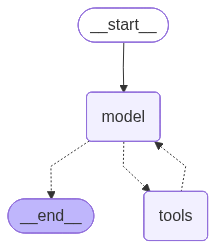

In [31]:
agent

Проверим, как работает инструмент удаления у обычного пользователя.

In [36]:
config = {"configurable": {"thread_id": "user_456-demo1"}}

res = agent.invoke(
    {"messages": [{"role": "user", "content": "Удали первую задачу из видимого тебе списка задач"}]},
    config,
    context=Context(user_id="user_456"),
)

for msg in res["messages"]:
    msg.pretty_print()

DEBUG SETTINGS: user_456 {'role': 'user', 'mode': 'plan'}
================================ Human Message =================================

Удали первую задачу из видимого тебе списка задач
================================== Ai Message ==================================

Сначала мне нужен полный список текущих задач, чтобы определить идентификатор первой задачи. 

Покажи мне список всех задач, пожалуйста.
Tool Calls:
  list_tasks (40ffa8d4-75e9-440a-88b0-fe046fa28727)
 Call ID: 40ffa8d4-75e9-440a-88b0-fe046fa28727
  Args:
================================= Tool Message =================================
Name: list_tasks

Текущие задачи:
#1: [in_progress] (p=5) Подготовить отчёт по продажам за квартал (due=2025-12-01)
#2: [todo] (p=4) Позвонить клиенту по продлению контракта
#5: [todo] (p=4) Сделать бэкап БД
#3: [todo] (p=1) Разобрать почту
================================== Ai Message ==================================
Tool Calls:
  delete_task (3ece7e72-0a00-40ef-b3b3-36f5330d8085)
 Cal

Теперь проверим у администратора.

In [37]:
config = {"configurable": {"thread_id": "user_123-demo"}}

res = agent.invoke(
    {"messages": [{"role": "user", "content": "Удали первую задачу из видимого тебе списка задач"}]},
    config,
    context=Context(user_id="user_123"),
)

for msg in res["messages"]:
    msg.pretty_print()

DEBUG SETTINGS: user_123 {'role': 'admin', 'mode': 'plan'}
DEBUG SETTINGS: user_123 {'role': 'admin', 'mode': 'apply'}
================================ Human Message =================================

Удали первую задачу из видимого тебе списка задач
================================== Ai Message ==================================
Tool Calls:
  list_tasks (be6d88f0-bedc-4f06-aef1-ba557b6c4ecd)
 Call ID: be6d88f0-bedc-4f06-aef1-ba557b6c4ecd
  Args:
================================= Tool Message =================================
Name: list_tasks

Текущие задачи:
#1: [in_progress] (p=5) Подготовить отчёт по продажам за квартал (due=2025-12-01)
#2: [todo] (p=4) Позвонить клиенту по продлению контракта
#5: [todo] (p=4) Сделать бэкап БД
#3: [todo] (p=1) Разобрать почту
================================== Ai Message ==================================
Tool Calls:
  delete_task (389c64de-b7f4-47b1-a4a1-ca291209f9c4)
 Call ID: 389c64de-b7f4-47b1-a4a1-ca291209f9c4
  Args:
    task_id: 1
===========

### Life-cycle Context

Рассмотрим модификацию контента между узлами model и tools на примере [Human-in-the-Loop](https://docs.langchain.com/oss/python/langchain/human-in-the-loop) (HITL), когда выполнение действия по обновлению статуса задачи требует подтверждение от пользователя.

Для реализации HITL будем использовать готовый класс `HumanInTheLoopMiddleware`. Этот Middleware позволяет выбрать инструменты, которые будут требовать вмешательства со стороны человека, а также допустимые действия. Мы для простоты применим его к `update_task_status()` с двумя возможными действиями: approve и reject.

In [38]:

from langchain.agents.middleware import HumanInTheLoopMiddleware


# HITL — просим вмешательство человека ТОЛЬКО для update_task_status
hitl_middleware = HumanInTheLoopMiddleware(
    interrupt_on={
        # для смены статуса всегда спрашиваем человека
        "update_task_status": {
            "allowed_decisions": ["approve", "reject"],
            "description": (
                "Модель хочет изменить статус задачи. "
                "Нужно решить, разрешить ли выполнение этого действия."
            ),
        },
        # остальные тулы считаем безопасными, без остановки
        "add_task": False,
        "list_tasks": False,
        "delete_task": False,
    },
    description_prefix="HITL:",  # просто префикс в описании, можно убрать
)

checkpointer_hitl = MemorySaver()

agent_hitl_status = create_agent(
    model=llm,
    tools=[add_task, list_tasks, update_task_status, delete_task],
    middleware=[hitl_middleware],
    checkpointer=checkpointer_hitl,
)


Как можно видеть, этот middleware добавляет ноду в граф перед вызовом инструмента.

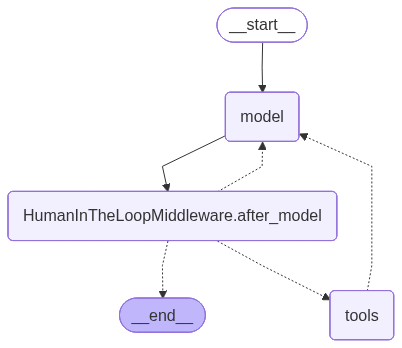

In [39]:
agent_hitl_status

In [40]:
from langgraph.types import Command

user_query = "Сделай все задачи выполненными (done)."
config = {"configurable": {"thread_id": "hitl"}}

# первый запуск агента
result = agent_hitl_status.invoke(
    {"messages": [{"role": "user", "content": user_query}]},
    config=config,
)

step = 1

while "__interrupt__" in result:
    print(f"\n=== ИНТЕРРАПТ #{step} ===")

    # result["__interrupt__"] — это список Interrupt(...) объектов
    interrupt_list = result["__interrupt__"]
    hitl_req = interrupt_list[0].value if isinstance(interrupt_list, list) else interrupt_list.value

    action_requests = hitl_req["action_requests"]
    review_configs = hitl_req["review_configs"]

    decisions = []

    for i, req in enumerate(action_requests, 1):
        name = req.get("name")
        # в твоей версии args лежат под ключом "args", а не "arguments"
        args = req.get("arguments") or req.get("args")
        desc = req.get("description")

        print(f"\nДействие #{i}")
        print(f"  tool = {name}")
        print(f"  args = {args}")
        print("  описание:")
        print(" ", desc)

        # Для простоты — только approve / reject
        while True:
            choice = input("Одобрить? (a = approve, r = reject): ").strip().lower()
            if choice in ("a", "r"):
                break

        if choice == "a":
            decisions.append({"type": "approve"})
        else:
            msg = input("Комментарий для агента (почему отклонено): ") or "Это действие отклонено человеком."
            decisions.append({"type": "reject", "message": msg})

    # Резюмируем выполнение графа с принятыми решениями
    result = agent_hitl_status.invoke(
        Command(resume={"decisions": decisions}),
        config=config
    )

    step += 1

# ---- 5. Агент завершил работу, печатаем историю ----
print("\n=== АГЕНТ ЗАВЕРШИЛ РАБОТУ ===")
for msg in result["messages"]:
    msg.pretty_print()


=== ИНТЕРРАПТ #1 ===

Действие #1
  tool = update_task_status
  args = {'new_status': 'done', 'task_id': 2}
  описание:
  Модель хочет изменить статус задачи. Нужно решить, разрешить ли выполнение этого действия.
Одобрить? (a = approve, r = reject): a

=== ИНТЕРРАПТ #2 ===

Действие #1
  tool = update_task_status
  args = {'new_status': 'done', 'task_id': 5}
  описание:
  Модель хочет изменить статус задачи. Нужно решить, разрешить ли выполнение этого действия.
Одобрить? (a = approve, r = reject): a

=== ИНТЕРРАПТ #3 ===

Действие #1
  tool = update_task_status
  args = {'new_status': 'done', 'task_id': 3}
  описание:
  Модель хочет изменить статус задачи. Нужно решить, разрешить ли выполнение этого действия.
Одобрить? (a = approve, r = reject): a

=== АГЕНТ ЗАВЕРШИЛ РАБОТУ ===
================================ Human Message =================================

Сделай все задачи выполненными (done).
================================== Ai Message ==================================
Tool Cal